<div style="background-color: skyblue; padding: 10px;">
    
## Setup

First, import all neccessary packages and define all the variables.

In [1]:
import os
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


%matplotlib inline

In [2]:
#all variables
data_classified = 'Data/classified'
data_raw = 'Data/raw'
data_alpha = 'Data/diversity'
data_abundance ='Data/abundance'

The biggest differences were found between the sterile and non-sterile environment during beta diversity analysis, so these will be looked at. 

In [3]:
#First, we look at the distribution of our data. 
data = q2.Artifact.load(f'{data_raw}/modified-dada1-table-highschool.qza').view(pd.DataFrame)

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


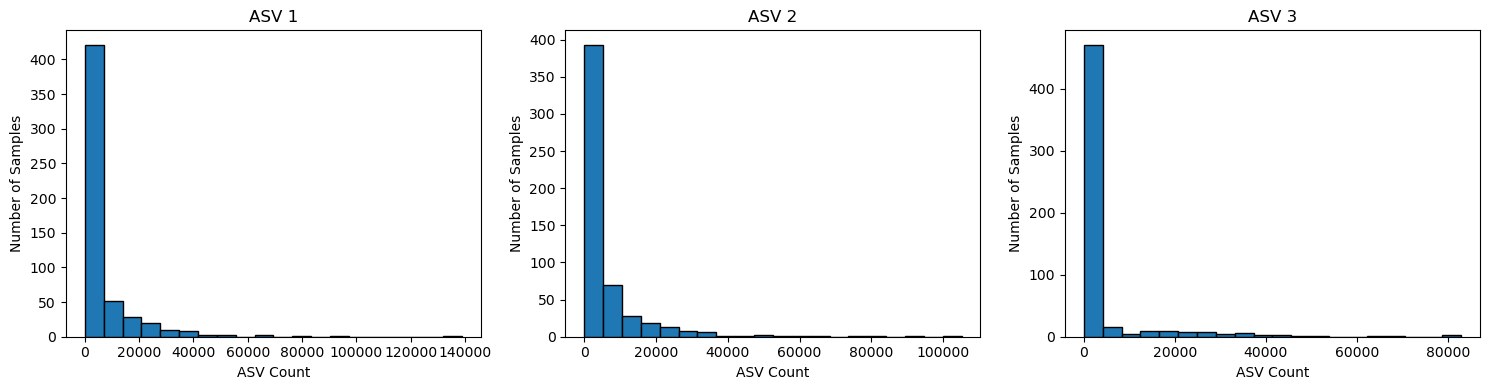


Top 3 ASV identifiers:
1. f228dd6b54c8587a0e366a57ab4d0904 (total: 3150979.0)
2. 23f8d77e0da2129f8b93b5ca894b5771 (total: 3065488.0)
3. c1f82285dd8e54d0759cc5b4589bd81e (total: 1907950.0)


In [7]:
data
# Get the top three most abundant sequence variants
# based on sum of observed sequence counts. Create a dataframe of ASV counts 
# with samples as rows and sequence variants as columns.
top_three = data[data.sum().nlargest(3).index]
# Your turn to try! Now view each of them as a histogram, as number of samples per ASV.
# View each as a histogram showing number of samples per ASV count value
import matplotlib.pyplot as plt

top_asv_names = top_three.columns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))


for i, asv in enumerate(top_asv_names):
    axes[i].hist(top_three[asv], bins=20, edgecolor='black')
    axes[i].set_xlabel('ASV Count')
    axes[i].set_ylabel('Number of Samples')
    axes[i].set_title(f'ASV {i+1}')

plt.tight_layout()
plt.show()

# Print the actual ASV identifiers
print("\nTop 3 ASV identifiers:")
for i, asv in enumerate(top_asv_names, 1):
    print(f"{i}. {asv} (total: {data[asv].sum()})")

<div style="background-color: skyblue; padding: 10px;">

## Filtering and ANCOM BC for sterile vs non-sterile evironment

Based on the shape of the data and the distribution of above, the following parameters for
filtering were chosen:

In [16]:

! qiime feature-table filter-features \
  --i-table $data_classified/table-filtered.qza \
  --p-min-frequency 50 \
  --p-min-samples 10 \
  --o-filtered-table $data_abundance/table_abund.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_abund.qza


In [7]:
#Check if there are any other values than sterile and non-sterile in the merged metadata in the background column
md_merged = pd.read_csv(f'{data_raw}/merged_output_usable.tsv', sep='\t')
md_merged['background'].unique()

array(['non-sterile', 'sterile', nan], dtype=object)

We want to look at differences betwen non-sterile and sterile environment since nan values are in df, filter for sterile and non-sterile values.

In [8]:

! qiime feature-table filter-samples \
    --i-table $data_abundance/table_abund.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-where "[background]='sterile' OR [background]='non-sterile'" \
    --o-filtered-table $data_abundance/table_abund_sterile_nonsterile.qza

#make it into a visualization
! qiime feature-table summarize \
    --i-table $data_abundance/table_abund_sterile_nonsterile.qza \
    --m-sample-metadata-file $data_raw/merged_output_usable.tsv \
    --o-visualization $data_abundance/table_abund_sterile_nonsterile.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile.qza
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/abundance/table_abund_sterile_nonsterile.qzv


In [21]:

# Run ANCOM-BC to test which ASVs differ between sterile and non-sterile
#first we start with an overall background comparison
! qiime composition ancombc \
    --i-table $data_abundance/table_abund_sterile_nonsterile.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-formula background \
    --o-differentials $data_abundance/ancombc_sterile_nonsterile_differentials.qza

# Generate a barplot of differentially abundant taxa between sterile and non-sterile backgrounds
! qiime composition da-barplot \
    --i-data $data_abundance/ancombc_sterile_nonsterile_differentials.qza \
    --o-visualization $data_abundance/ancombc_sterile_nonsterile_da_barplot.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_differentials.qza


In [4]:

Visualization.load(f"{data_abundance}/ancombc_sterile_nonsterile_da_barplot.qzv")

<visualization: Visualization uuid: 7ed5166e-a4a4-4533-8e97-e08219b98ac5>

A difference between sterile and non-sterile environment could be observed. In the next step, 
in the next step it will be observed how these change over time. 

<div style="background-color: skyblue; padding: 10px;">

## ANCOM BC to see differences between sterile and non-sterile environment over time

Now we did a general analysis, and saw there were definetly some samples
enriched vs. depleted in the analysis. Now we want to try and answer the 
following questions by differential abundance: 
2. How did the fungal communities change over time between sterile vs.
non-sterile starter backgrounds? Is one background more ‘resilient’ towards
invading fungi directly coming from participants' hands?
3. Which taxa consistently transfer from hand to dough — and which resist
colonization?

We try to answer this question first:  2. How did the fungal communities change over time between sterile vs.
non-sterile starter backgrounds? Is one background more ‘resilient’ towards
invading fungi directly coming from participants' hands?
For this, we want to run a ANCOM bc test between sterile vs non-sterile background
at the different time points (we have the time points 0, 7, 14 and 21). Additionally, we will filter for the sourdough sample type, because we are interested in how the communities changed in the sourdoughs. 

In [33]:
#Some data in the day column are empty, so first we need to filter the metadata df for only 
#data where there is a time point
md_time = pd.read_csv(f'{data_raw}/merged_output_usable.tsv', sep='\t')
# Drop rows where 'day' column is missing/empty
md_time = md_time[md_time['day'].notna()].copy()
# Save to new file
md_time.to_csv(f'{data_raw}/md_time.tsv', sep='\t', index=False)

For loop through each time point, to run ANCOM BC test at each time point for sterile 
and non-sterile environment. We will exclude hand_swab samples.

In [3]:
# Different time points 
days = [7, 14, 21]
# Loop through each day
for day in days:
    print(f"Processing day {day}...")
    
    # Filter for current day samples AND sourdough sample type
    os.system(f"""qiime feature-table filter-samples \
        --i-table {data_abundance}/table_abund_sterile_nonsterile.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-where "[day]='{day}' AND [sample_type]='sourdough'" \
        --o-filtered-table {data_abundance}/table_abund_sterile_nonsterile_day{day}.qza""")
    
    # Run ANCOM-BC on current day
    os.system(f"""qiime composition ancombc \
        --i-table {data_abundance}/table_abund_sterile_nonsterile_day{day}.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-formula background \
        --o-differentials {data_abundance}/ancombc_sterile_nonsterile_day{day}_differentials.qza""")
    
    print(f"Completed day {day}\n")
print("All days processed!")

Processing day 7...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day7.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day7_differentials.qza
Completed day 7

Processing day 14...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day14.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day14_differentials.qza
Completed day 14

Processing day 21...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day21.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day21_differentials.qza
Completed day 21

All days processed!


In [5]:
#Export the results of each time point
import os

# Export each time point's results
days = [7, 14, 21]
for day in days:
    os.system(f"""
        qiime tools export \
            --input-path {data_abundance}/ancombc_sterile_nonsterile_day{day}_differentials.qza \
            --output-path {data_abundance}/exported_day{day}
    """)

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_day7_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_day7


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_day14_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_day14


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_day21_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_day21


In [6]:

days = [7, 14, 21] 

# Load the differential abundance results for each time point 
results = {} 

for day in days: 
    # Read all the slice files
    lfc = pd.read_csv(f"{data_abundance}/exported_day{day}/lfc_slice.csv", index_col=0)
    p_val = pd.read_csv(f"{data_abundance}/exported_day{day}/p_val_slice.csv", index_col=0) 
    q_val = pd.read_csv(f"{data_abundance}/exported_day{day}/q_val_slice.csv", index_col=0) 
    se = pd.read_csv(f"{data_abundance}/exported_day{day}/se_slice.csv", index_col=0)
    w = pd.read_csv(f"{data_abundance}/exported_day{day}/w_slice.csv", index_col=0) 
    
    # Combine into one dataframe
    df = pd.DataFrame({
        'lfc': lfc.iloc[:, 0], 
        'p_val': p_val.iloc[:, 0], 
        'q_val': q_val.iloc[:, 0], 
        'se': se.iloc[:, 0], 
        'w': w.iloc[:, 0]
    }) 
    
    df.index.name = 'id'
    df = df.reset_index()
    results[day] = df

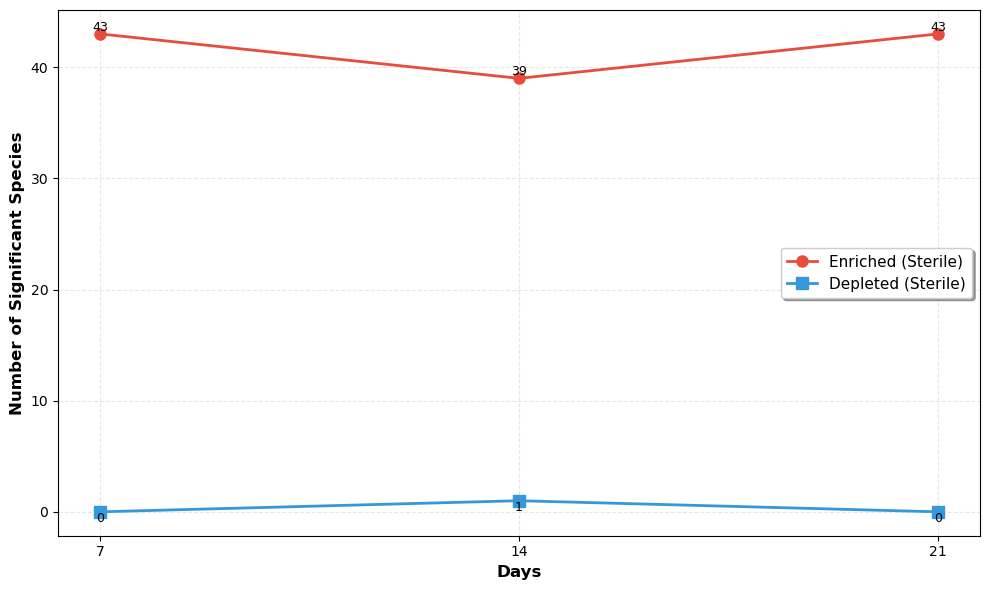

In [9]:
# Count enriched and depleted species at each time point
# Using q-value < 0.05 for significance and lfc for direction
enriched_counts = []
depleted_counts = []
significance_threshold = 0.05
for day in days:
    df = results[day]
    
    # Significant enriched (lfc > 0, q_val < 0.05)
    enriched = df[(df['lfc'] > 0) & (df['q_val'] < significance_threshold)].shape[0]
    
    # Significant depleted (lfc < 0, q_val < 0.05)
    depleted = df[(df['lfc'] < 0) & (df['q_val'] < significance_threshold)].shape[0]
    
    enriched_counts.append(enriched)
    depleted_counts.append(depleted)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(days, enriched_counts, marker='o', linewidth=2, markersize=8, 
        label='Enriched (Sterile)', color='#e74c3c')
ax.plot(days, depleted_counts, marker='s', linewidth=2, markersize=8, 
        label='Depleted (Sterile)', color='#3498db')
ax.set_xlabel('Days', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Significant Species', fontsize=12, fontweight='bold')
ax.legend(fontsize=11, frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xticks(days)

# Add value labels on points
for i, day in enumerate(days):
    ax.text(day, enriched_counts[i], str(enriched_counts[i]), 
            ha='center', va='bottom', fontsize=9)
    ax.text(day, depleted_counts[i], str(depleted_counts[i]), 
            ha='center', va='top', fontsize=9)

plt.tight_layout()
plt.show()

<div style="background-color: skyblue; padding: 10px;">

## Analysis on the species level

Now, let's do the same with species identification. For this we need to collapse the 
table on species level. 

In [34]:

! qiime taxa collapse \
    --i-table $data_abundance/table_abund.qza \
    --i-taxonomy $data_classified/taxonomy.qza \
    --p-level 7 \
    --o-collapsed-table $data_abundance/table_abund_l7.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_abund_l7.qza


Run ANCOM BC on species level for all the different time points.

In [14]:
import os

# Define the days to process
days = [7, 14, 21]

# Loop through each day
for day in days:
    print(f"Processing day {day}...")
    
    # Filter for current day samples AND sourdough sample type
    status1 = os.system(f"""qiime feature-table filter-samples \
        --i-table {data_abundance}/table_abund_l7.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-where "[day]='{day}' AND [sample_type]='sourdough'" \
        --o-filtered-table {data_abundance}/table_abund_sterile_nonsterile_l7_day{day}.qza""")
    
    if status1 != 0:
        print(f"Error filtering day {day}")
        continue
    
    # Run ANCOM-BC on current day with explicit reference level
    status2 = os.system(f"""qiime composition ancombc \
        --i-table {data_abundance}/table_abund_sterile_nonsterile_l7_day{day}.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-formula background \
        --p-reference-levels background::non-sterile \
        --o-differentials {data_abundance}/ancombc_sterile_nonsterile_l7_day{day}_differentials.qza""")
    
    if status2 != 0:
        print(f"Error running ANCOM-BC for day {day}")
    else:
        print(f"✓ Completed day {day}\n")
        
print("All days processed!")

Processing day 7...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_l7_day7.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_l7_day7_differentials.qza
✓ Completed day 7

Processing day 14...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_l7_day14.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_l7_day14_differentials.qza
✓ Completed day 14

Processing day 21...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_l7_day21.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_l7_day21_differentials.qza
✓ Completed day 21

All days processed!


In [16]:


# Export each time point's results
days = [7, 14, 21]

for day in days:
    print(f"Exporting day {day} results...")
    
    status = os.system(f"""qiime tools export \
        --input-path {data_abundance}/ancombc_sterile_nonsterile_l7_day{day}_differentials.qza \
        --output-path {data_abundance}/exported_l7_day{day}""")
    
    if status != 0:
        print(f"Error exporting day {day}")
    else:
        print(f"✓ Exported day {day}\n")

print("All exports completed!")

Exporting day 0 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_l7_day0_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_day0
✓ Exported day 0

Exporting day 7 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_l7_day7_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_day7
✓ Exported day 7

Exporting day 14 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_l7_day14_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_day14
✓ Exported day 14

Exporting day 21 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_l7_day21_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_day21
✓ Exported day 21

All exports completed!


In [15]:
# Load the differential species abundance results for each time point
days = [7, 14, 21]
results_species_level = {}

for day in days:
    lfc = pd.read_csv(f"{data_abundance}/exported_l7_day{day}/lfc_slice.csv", index_col=0)
    p_val = pd.read_csv(f"{data_abundance}/exported_l7_day{day}/p_val_slice.csv", index_col=0)
    q_val = pd.read_csv(f"{data_abundance}/exported_l7_day{day}/q_val_slice.csv", index_col=0)
    se = pd.read_csv(f"{data_abundance}/exported_l7_day{day}/se_slice.csv", index_col=0)
    w = pd.read_csv(f"{data_abundance}/exported_l7_day{day}/w_slice.csv", index_col=0)
    
    df = pd.DataFrame({
        'lfc': lfc.iloc[:, 0],
        'p_val': p_val.iloc[:, 0],
        'q_val': q_val.iloc[:, 0],
        'se': se.iloc[:, 0],
        'w': w.iloc[:, 0]
    })
    df.index.name = 'id'
    df = df.reset_index()
    results_species_level[day] = df

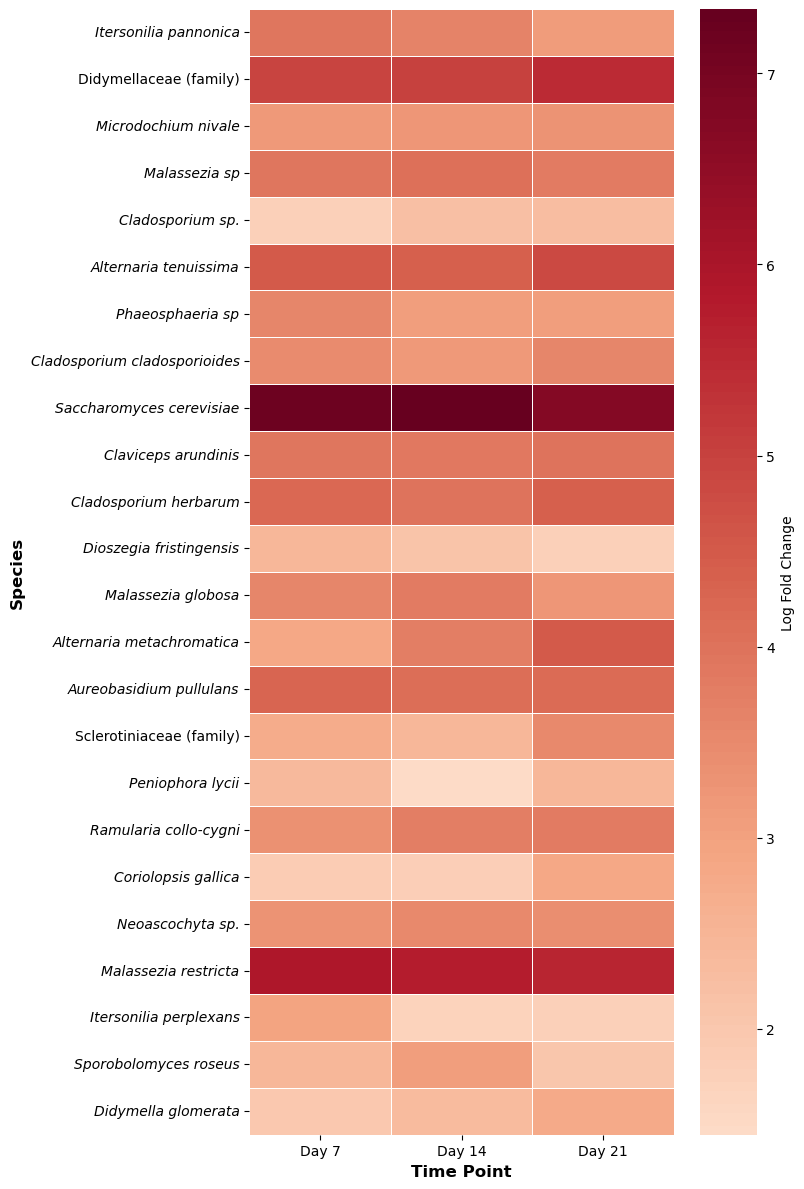

In [19]:
import seaborn as sns

# Function to extract clean species name with fallback to higher taxonomic levels
def extract_species_name(full_taxonomy):
    """Extract genus and species from full taxonomy string, with fallback to higher levels"""
    parts = full_taxonomy.split(';')
    genus = ''
    species = ''
    family = ''
    order = ''
    class_name = ''
    phylum = ''
    
    for part in parts:
        part = part.strip()
        if part.startswith('p__'):
            phylum = part.replace('p__', '').strip()
        elif part.startswith('c__'):
            class_name = part.replace('c__', '').strip()
        elif part.startswith('o__'):
            order = part.replace('o__', '').strip()
        elif part.startswith('f__'):
            family = part.replace('f__', '').strip()
        elif part.startswith('g__'):
            genus = part.replace('g__', '').strip()
        elif part.startswith('s__'):
            species_raw = part.replace('s__', '').strip().replace('_', ' ')
            if genus and species_raw.startswith(genus):
                species = species_raw[len(genus):].strip()
            else:
                species = species_raw
    
    # Return the most specific level available
    if genus and species:
        return f"{genus} {species}"
    elif genus:
        return f"{genus} sp."
    elif family:
        return f"{family} (family)"
    elif order:
        return f"{order} (order)"
    elif class_name:
        return f"{class_name} (class)"
    elif phylum:
        return f"{phylum} (phylum)"
    else:
        # Last resort: return the last part
        return full_taxonomy.split(';')[-1].strip().replace('s__', '').replace('_', ' ')

# Collect top differential species across all timepoints
top_species_per_day = {}
n_top = 20  # Show top 20 species per timepoint
for day in days:
    df = results_species_level[day]
    # Filter significant species
    sig_species = df[df['q_val'] < 0.05].copy()
    # Sort by absolute log fold change
    sig_species['abs_lfc'] = sig_species['lfc'].abs()
    sig_species = sig_species.sort_values('abs_lfc', ascending=False)
    top_species_per_day[day] = sig_species.head(n_top)

# Get union of all top species across timepoints
all_top_species = set()
for day_df in top_species_per_day.values():
    all_top_species.update(day_df['id'].tolist())

# Create matrix of LFC values
lfc_matrix = []
species_list = list(all_top_species)

# Create clean species names for labels
species_labels = [extract_species_name(species) for species in species_list]

for species in species_list:
    lfc_row = []
    for day in days:
        df = results_species_level[day]
        species_data = df[df['id'] == species]
        if len(species_data) > 0:
            lfc_row.append(species_data['lfc'].values[0])
        else:
            lfc_row.append(0)
    lfc_matrix.append(lfc_row)

# Create heatmap
fig, ax = plt.subplots(figsize=(8, 12))
sns.heatmap(lfc_matrix, 
            xticklabels=[f'Day {d}' for d in days],
            yticklabels=species_labels,  # Use clean species names
            cmap='RdBu_r',
            center=0,
            cbar_kws={'label': 'Log Fold Change'},
            linewidths=0.5,
            ax=ax)

ax.set_xlabel('Time Point', fontsize=12, fontweight='bold')
ax.set_ylabel('Species', fontsize=12, fontweight='bold')

# Make y-axis labels italic for genus/species, regular for higher taxonomic levels
for i, label in enumerate(ax.get_yticklabels()):
    label_text = species_labels[i]
    # Only italicize if it's a genus or species name (no parentheses)
    if '(' not in label_text:
        label.set_fontstyle('italic')

plt.tight_layout()
plt.savefig('species_heatmap_lfc.png', dpi=300, bbox_inches='tight')
plt.show()

<div style="background-color: skyblue; padding: 10px;">

## ANCOM BC analysis for hand and sourdough over time

First, check if there are differences between hand and sourdough.

In [8]:

#check for unique values in the sample_type column
md_merged['sample_type'].unique()

array(['sourdough', 'control_n', 'control_pcr', 'control_p', 'empty',
       'hand_swabs'], dtype=object)

In [25]:

#Filter for hand_swabs and sourdough samples
! qiime feature-table filter-samples \
    --i-table $data_abundance/table_abund.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-where "[sample_type]='hand_swabs' OR [sample_type]='sourdough'" \
    --o-filtered-table $data_abundance/table_hand_dough.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_hand_dough.qza


In [4]:
! qiime composition ancombc \
    --i-table $data_abundance/table_hand_dough.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-formula "sample_type" \
    --p-reference-levels "sample_type::hand_swabs" \
    --o-differentials $data_abundance/table_hand_dough_person_filtered.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[DifferentialAbundance] to: Data/abundance/table_hand_dough_person_filtered.qza


In [15]:
! qiime tools export \
    --input-path $data_abundance/table_hand_dough_person_filtered.qza \
    --output-path $data_abundance/exported_hand_vs_dough

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Exported Data/abundance/table_hand_dough_person_filtered.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_hand_vs_dough


In [5]:
#turn into visualization 
! qiime composition tabulate \
    --i-data $data_abundance/table_hand_dough_person_filtered.qza \
    --o-visualization $data_abundance/table_hand_dough_person_filtered.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/abundance/table_hand_dough_person_filtered.qzv


In [7]:
#Visualize
! qiime composition da-barplot \
    --i-data $data_abundance/table_hand_dough_person_filtered.qza \
    --o-visualization $data_abundance/ancombc_hand_dough_barplot.qzv


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/abundance/ancombc_hand_dough_barplot.qzv


In [9]:
Visualization.load(f"Data/abundance/table_hand_dough_person_filtered.qzv")

<visualization: Visualization uuid: 6073e2d3-2d82-4e38-9076-f4bc7078c503>

In [15]:
Visualization.load(f"Data/abundance/ancombc_hand_dough_barplot.qzv")

<visualization: Visualization uuid: 7f0b92d8-1602-4920-bf40-9cbaf8377179>

<div style="background-color: skyblue; padding: 10px;">

## ANCOM BC analysis for sourdough vs hand over time in sterile and non-sterile background

We saw that there is a difference between hand and sourdough taxa. Now we want to compare the hand and sourdough taxa over time in the sterile vs non-sterile environment. For this we once do the ANCOM BC test for the sterile environment and once for the non-sterile environment. 

### Sterile environment

In [11]:
#Looping through the different time points again for sourdough vs. hand_swabs for 
#the sterile environment
#Hand_swabs will be used as reference by qime-2, because of alphabetical order

# Define the days to process
days = [0, 7, 14, 21]

# Loop through each day
for day in days:
    print(f"Processing day {day}...")
    
    # Filter for current day samples (hand_swabs and sourdough only, sterile background)
    status1 = os.system(f"""qiime feature-table filter-samples \
        --i-table {data_abundance}/table_abund_l7.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-where "[day]='{day}' AND ([sample_type]='hand_swabs' OR [sample_type]='sourdough') AND [background]='sterile'" \
        --o-filtered-table {data_abundance}/table_abund_hand_vs_sourdough_l7_day{day}.qza""")
    
    if status1 != 0:
        print(f"Error filtering day {day}")
        continue
    
    # Run ANCOM-BC on current day (comparing sample_type instead of background)
    status2 = os.system(f"""qiime composition ancombc \
        --i-table {data_abundance}/table_abund_hand_vs_sourdough_l7_day{day}.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-formula sample_type \
        --o-differentials {data_abundance}/ancombc_l7_sterile_day{day}_differentials.qza""")
    
    if status2 != 0:
        print(f"Error running ANCOM-BC for day {day}")
    else:
        print(f"✓ Completed day {day}\n")

print("All days processed!")

Processing day 0...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day0.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Plugin error from composition:

  An error was encountered while running ANCOM-BC in R (return code 1), please inspect stdout and stderr to learn more.

Debug info has been saved to /tmp/qiime2-q2cli-err-fhj4ju_t.log


Error running ANCOM-BC for day 0
Processing day 7...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day7.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_l7_sterile_day7_differentials.qza
✓ Completed day 7

Processing day 14...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day14.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_l7_sterile_day14_differentials.qza
✓ Completed day 14

Processing day 21...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day21.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_l7_sterile_day21_differentials.qza
✓ Completed day 21

All days processed!



There is no data for the sourdoughs from day 0, so day 0 will be excluded from the analysis. 

In [13]:
# Export each time point's results for sterile environment
days = [7, 14, 21]
for day in days:
    print(f"Exporting day {day} results...")
    
    status = os.system(f"""qiime tools export \
        --input-path {data_abundance}/ancombc_l7_sterile_day{day}_differentials.qza \
        --output-path {data_abundance}/exported_l7_sterile_day{day}""")
    
    if status != 0:
        print(f"Error exporting day {day}")
    else:
        print(f"✓ Exported day {day}\n")
print("All exports completed!")

Exporting day 7 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_l7_sterile_day7_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_sterile_day7
✓ Exported day 7

Exporting day 14 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_l7_sterile_day14_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_sterile_day14
✓ Exported day 14

Exporting day 21 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_l7_sterile_day21_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_sterile_day21
✓ Exported day 21

All exports completed!


In [31]:
#Load the results into pandas
results_species_level_sterile = {}
days = [7, 14, 21]
for day in days:
    lfc = pd.read_csv(f"{data_abundance}/exported_l7_sterile_day{day}/lfc_slice.csv", index_col=0)
    p_val = pd.read_csv(f"{data_abundance}/exported_l7_sterile_day{day}/p_val_slice.csv", index_col=0)
    q_val = pd.read_csv(f"{data_abundance}/exported_l7_sterile_day{day}/q_val_slice.csv", index_col=0)
    se = pd.read_csv(f"{data_abundance}/exported_l7_sterile_day{day}/se_slice.csv", index_col=0)
    w = pd.read_csv(f"{data_abundance}/exported_l7_sterile_day{day}/w_slice.csv", index_col=0)
    
    df = pd.DataFrame({
        'lfc': lfc.iloc[:, 0],
        'p_val': p_val.iloc[:, 0],
        'q_val': q_val.iloc[:, 0],
        'se': se.iloc[:, 0],
        'w': w.iloc[:, 0]
    })
    df.index.name = 'id'
    df = df.reset_index()
    results_species_level_sterile[day] = df


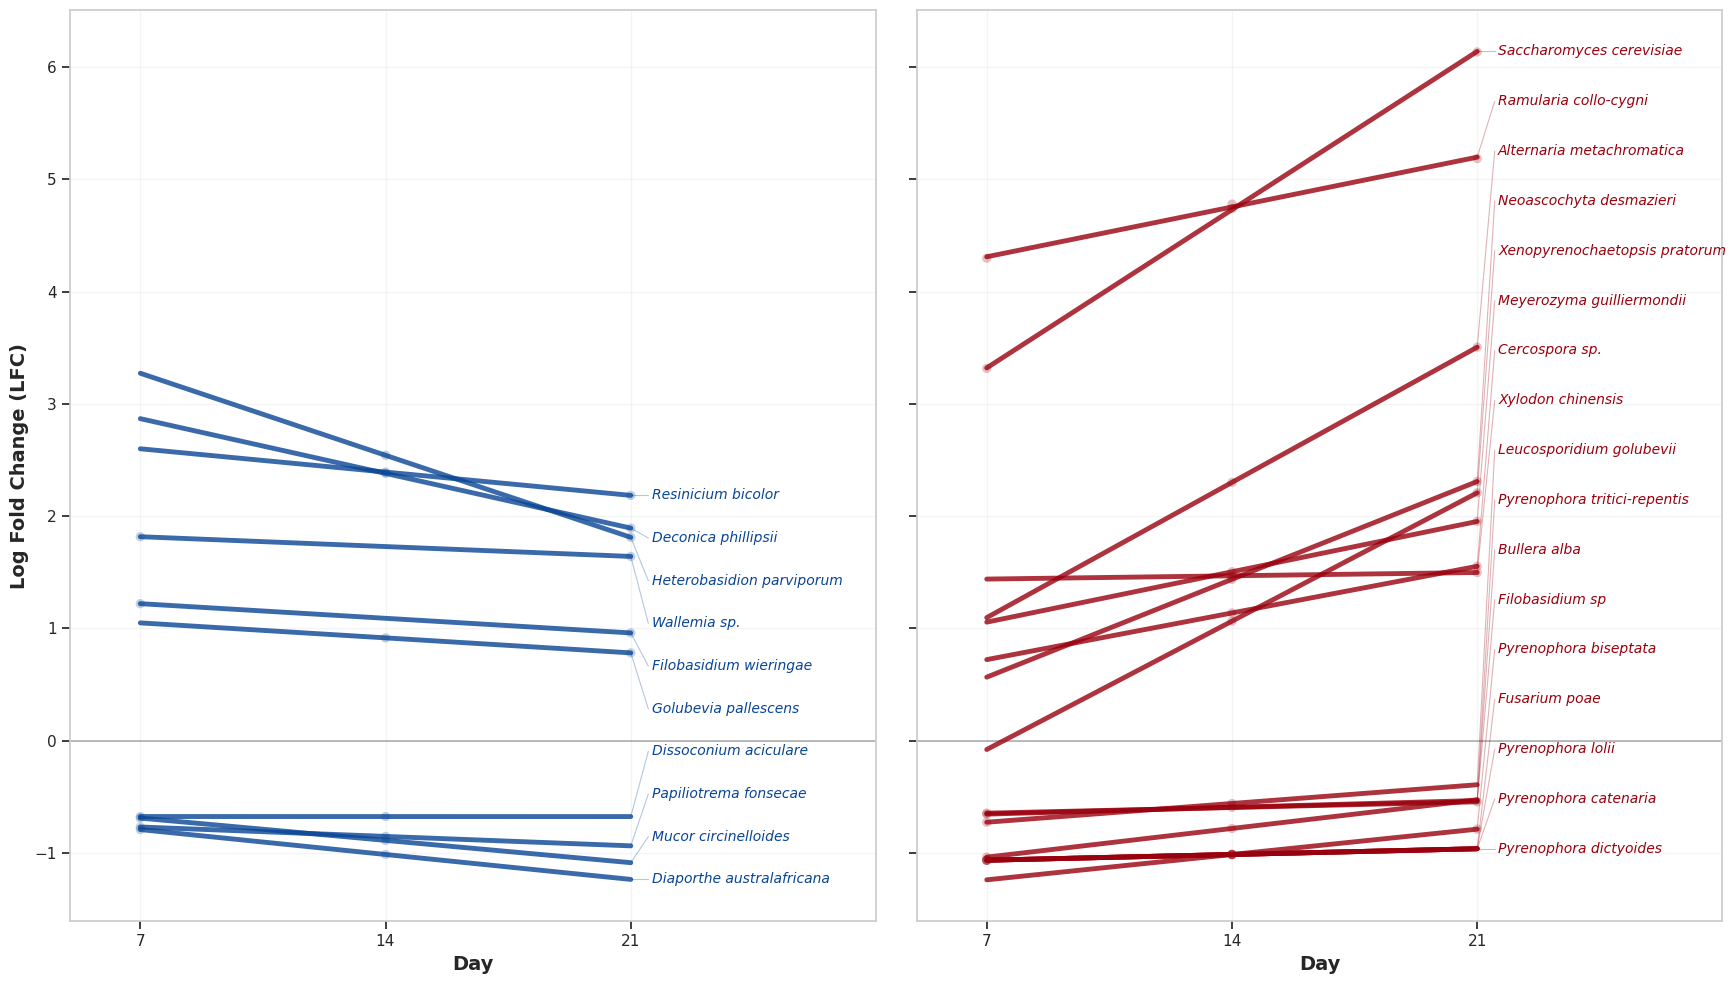


STERILE ENVIRONMENT: 27 species with significant directional changes (p < 0.05 for slope):
  Transfer: 10
  Depletion: 17

DISPLAY NAME                                  | Slope   | R²    | P-Value 

--- TRANSFER TAXA ---
Heterobasidion parviporum                     | -0.1044 | 1.00 | 0.00e+00
Deconica phillipsii                           | -0.0696 | 1.00 | 0.00e+00
Diaporthe australafricana                     | -0.0317 | 1.00 | 0.00e+00
Resinicium bicolor                            | -0.0296 | 1.00 | 0.00e+00
Mucor circinelloides                          | -0.0284 | 1.00 | 0.00e+00
Golubevia pallescens                          | -0.0191 | 1.00 | 0.00e+00
Filobasidium wieringae                        | -0.0186 | 1.00 | 0.00e+00
Wallemia sp.                                  | -0.0125 | 1.00 | 0.00e+00
Papiliotrema fonsecae                         | -0.0120 | 1.00 | 0.00e+00
Dissoconium aciculare                         | -0.0000 | 1.00 | 0.00e+00

--- DEPLETION TAXA ---
Saccharomyces 

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats

# === 1. TAXONOMY EXTRACTION FUNCTION ===
def extract_species_name(full_taxonomy):
    """Extracts the most specific name available, avoiding empty underscores."""
    if not isinstance(full_taxonomy, str) or full_taxonomy.strip() == "" or full_taxonomy == "__":
        return "Unknown Taxon"
        
    parts = [p.strip() for p in full_taxonomy.split(';')]
    
    # Dictionaries to hold the ranks
    ranks = {'s__': '', 'g__': '', 'f__': '', 'o__': '', 'c__': '', 'p__': ''}
    
    for part in parts:
        for key in ranks.keys():
            if part.startswith(key):
                # Clean name: remove prefix and underscores
                name = part.replace(key, '').replace('_', ' ').strip()
                if name: # Only store if not empty
                    ranks[key] = name

    # 1. Try Species + Genus
    if ranks['s__'] and ranks['g__']:
        if ranks['s__'].lower().startswith(ranks['g__'].lower()):
            return ranks['s__']
        return f"{ranks['g__']} {ranks['s__']}"
    
    # 2. Try Genus only
    if ranks['g__']:
        return f"{ranks['g__']} sp."
    
    # 3. Fallback to Family, Order, etc.
    for rank in ['f__', 'o__', 'c__', 'p__']:
        if ranks[rank]:
            return f"{ranks[rank]} (family/order)"

    # 4. Ultimate fallback: last part that isn't just an underscore
    clean_parts = [p.split('__')[-1].replace('_', ' ').strip() for p in parts if len(p.split('__')[-1].replace('_', ' ').strip()) > 0]
    return clean_parts[-1] if clean_parts else "Unclassified Taxon"

# === 2. DATA PREPARATION (STERILE) & REGRESSION ===
# Combine all days and filter significant species (q_val < 0.05)
combined_sterile = pd.concat([
    df[df['q_val'] < 0.05].assign(day=day) 
    for day, df in results_species_level_sterile.items()
])

# Filter: Keep only species with at least 2 timepoints for valid regression
species_counts = combined_sterile['id'].value_counts()
multi_timepoint = combined_sterile[combined_sterile['id'].isin(
    species_counts[species_counts >= 2].index
)]

# Regression Analysis
regression_results = []
for species, data in multi_timepoint.groupby('id'):
    slope, intercept, r_value, p_value, _ = stats.linregress(data['day'], data['lfc'])
    regression_results.append({
        'species': species,
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2,
        'p_value': p_value
    })

regression_df = pd.DataFrame(regression_results).sort_values('slope')

# CLASSIFICATION LOGIC (p < 0.05 and direction)
regression_df['pattern'] = regression_df.apply(
    lambda r: 'Transfer' if r['p_value'] < 0.05 and r['slope'] < 0 
    else 'Depletion' if r['p_value'] < 0.05 and r['slope'] > 0 
    else 'No change', axis=1
)

# Filter for significant directional changes
filtered_df = regression_df[regression_df['pattern'] != 'No change'].copy()
filtered_df['display_name'] = filtered_df['species'].apply(extract_species_name)
selected_species = filtered_df

# === 3. VISUALIZATION (Prominent Lines & Faceted) ===
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), sharey=True)

axes = {'Transfer': ax1, 'Depletion': ax2}
colors = {'Transfer': '#084594', 'Depletion': '#99000d'}

for pattern in ['Transfer', 'Depletion']:
    ax = axes[pattern]
    subset = selected_species[selected_species['pattern'] == pattern].copy()
    
    # Sort for cleaner labeling
    subset['final_y'] = subset['slope'] * 21 + subset['intercept']
    subset = subset.sort_values('final_y')
    
    color = colors[pattern]
    
    for _, reg in subset.iterrows():
        species_data = multi_timepoint[multi_timepoint['id'] == reg['species']].sort_values('day')
        
        # Plot data points
        ax.scatter(species_data['day'], species_data['lfc'], 
                   color=color, s=45, alpha=0.25, edgecolors='none', zorder=2)
        
        # Prominent Regression Lines
        x_line = np.array([7, 14, 21])
        y_line = reg['slope'] * x_line + reg['intercept']
        ax.plot(x_line, y_line, color=color, linewidth=3.5, alpha=0.8, zorder=3)

    # Rank-based Labeling
    if not subset.empty:
        y_min, y_max = subset['final_y'].min(), subset['final_y'].max()
        spread_y = np.linspace(y_min, y_max, len(subset)) if len(subset) > 1 else [y_min]
        
        for i, (_, reg) in enumerate(subset.iterrows()):
            actual_y = reg['final_y']
            target_y = spread_y[i]
            
            ax.text(21.6, target_y, reg['display_name'], 
                    fontsize=10, color=color, va='center', fontweight='medium', fontstyle='italic')
            
            # Helper connector lines
            ax.plot([21, 21.5], [actual_y, target_y], color=color, lw=0.8, alpha=0.3)

    # Axis Formatting
    ax.axhline(0, color='black', linestyle='-', linewidth=1.2, alpha=0.3)
    ax.set_xticks([7, 14, 21])
    ax.set_xlim(5, 28)
    ax.set_xlabel('Day', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.2)

# Updated Y-Label
ax1.set_ylabel('Log Fold Change (LFC)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# === 4. SUMMARY STATISTICS ===
print(f"\nSTERILE ENVIRONMENT: {len(filtered_df)} species with significant directional changes (p < 0.05 for slope):")
print(f"  Transfer: {(filtered_df['pattern'] == 'Transfer').sum()}")
print(f"  Depletion: {(filtered_df['pattern'] == 'Depletion').sum()}")

print("\n" + "="*80)
print(f"{'DISPLAY NAME':<45} | {'Slope':<7} | {'R²':<5} | {'P-Value':<8}")
print("="*80)

for p in ['Transfer', 'Depletion']:
    print(f"\n--- {p.upper()} TAXA ---")
    # Sort by absolute slope to show strongest trends first
    subset = filtered_df[filtered_df['pattern'] == p].sort_values('slope', ascending=(p=='Transfer'))
    for _, row in subset.iterrows():
        print(f"{row['display_name']:45} | {row['slope']:7.4f} | {row['r_squared']:.2f} | {row['p_value']:.2e}")

### Non-sterile environment

In [ ]:
#And once for the non-sterile environment
# Define the days to process
#Hand_swabs will be used as reference by qime-2, because of alphabetical order
days = [7, 14, 21]

# Loop through each day
for day in days:
    print(f"Processing day {day}...")
    
    # Filter for current day samples (hand_swabs and sourdough only, non-sterile background)
    status1 = os.system(f"""qiime feature-table filter-samples \
        --i-table {data_abundance}/table_abund_l7.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-where "[day]='{day}' AND ([sample_type]='hand_swabs' OR [sample_type]='sourdough') AND [background]='non-sterile'" \
        --o-filtered-table {data_abundance}/table_abund_hand_vs_sourdough_l7_day{day}.qza""")
    
    if status1 != 0:
        print(f"Error filtering day {day}")
        continue
    
    # Run ANCOM-BC on current day (comparing sample_type instead of background)
    status2 = os.system(f"""qiime composition ancombc \
        --i-table {data_abundance}/table_abund_hand_vs_sourdough_l7_day{day}.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-formula sample_type \
        --o-differentials {data_abundance}/ancombc_non_sterile_day{day}_differentials.qza""")
    
    if status2 != 0:
        print(f"Error running ANCOM-BC for day {day}")
    else:
        print(f"✓ Completed day {day}\n")

print("All days processed!")

Processing day 7...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day7.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_non_sterile_day7_differentials.qza
✓ Completed day 7

Processing day 14...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day14.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_non_sterile_day14_differentials.qza
✓ Completed day 14

Processing day 21...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day21.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [20]:

# Export each time point's results for non-sterile environment
days = [7, 14, 21]
for day in days:
    print(f"Exporting day {day} results...")
    
    status = os.system(f"""qiime tools export \
        --input-path {data_abundance}/ancombc_non_sterile_day{day}_differentials.qza \
        --output-path {data_abundance}/exported_non_sterile_day{day}""")
    
    if status != 0:
        print(f"Error exporting day {day}")
    else:
        print(f"✓ Exported day {day}\n")
print("All exports completed!")

Exporting day 0 results...
Error exporting day 0
Exporting day 7 results...


Usage: qiime tools export [OPTIONS]

  Exporting extracts (and optionally transforms) data stored inside an
  Artifact or Visualization. Note that Visualizations cannot be transformed
  with --output-format

Options:
  --input-path ARTIFACT/VISUALIZATION
                        Path to file that should be exported        [required]
  --output-path PATH    Path to file or directory where data should be
                        exported to                                 [required]
  --output-format TEXT  Format which the data should be exported as. This
                        option cannot be used with Visualizations
  --help                Show this message and exit.

                    There was a problem with the command:                     
 (1/1) Invalid value for '--input-path': File
  'Data/abundance/ancombc_non_sterile_day0_differentials.qza' does not exist.
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See h

Exported Data/abundance/ancombc_non_sterile_day7_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_non_sterile_day7
✓ Exported day 7

Exporting day 14 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_non_sterile_day14_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_non_sterile_day14
✓ Exported day 14

Exporting day 21 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_non_sterile_day21_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_non_sterile_day21
✓ Exported day 21

All exports completed!


In [26]:
# Load the results into pandas for non-sterile environment
results_species_level_non_sterile = {}
days = [7, 14, 21]
for day in days:
    lfc = pd.read_csv(f"{data_abundance}/exported_non_sterile_day{day}/lfc_slice.csv", index_col=0)
    p_val = pd.read_csv(f"{data_abundance}/exported_non_sterile_day{day}/p_val_slice.csv", index_col=0)
    q_val = pd.read_csv(f"{data_abundance}/exported_non_sterile_day{day}/q_val_slice.csv", index_col=0)
    se = pd.read_csv(f"{data_abundance}/exported_non_sterile_day{day}/se_slice.csv", index_col=0)
    w = pd.read_csv(f"{data_abundance}/exported_non_sterile_day{day}/w_slice.csv", index_col=0)
    
    df = pd.DataFrame({
        'lfc': lfc.iloc[:, 0],
        'p_val': p_val.iloc[:, 0],
        'q_val': q_val.iloc[:, 0],
        'se': se.iloc[:, 0],
        'w': w.iloc[:, 0]
    })
    df.index.name = 'id'
    df = df.reset_index()
    results_species_level_non_sterile[day] = df
    

/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


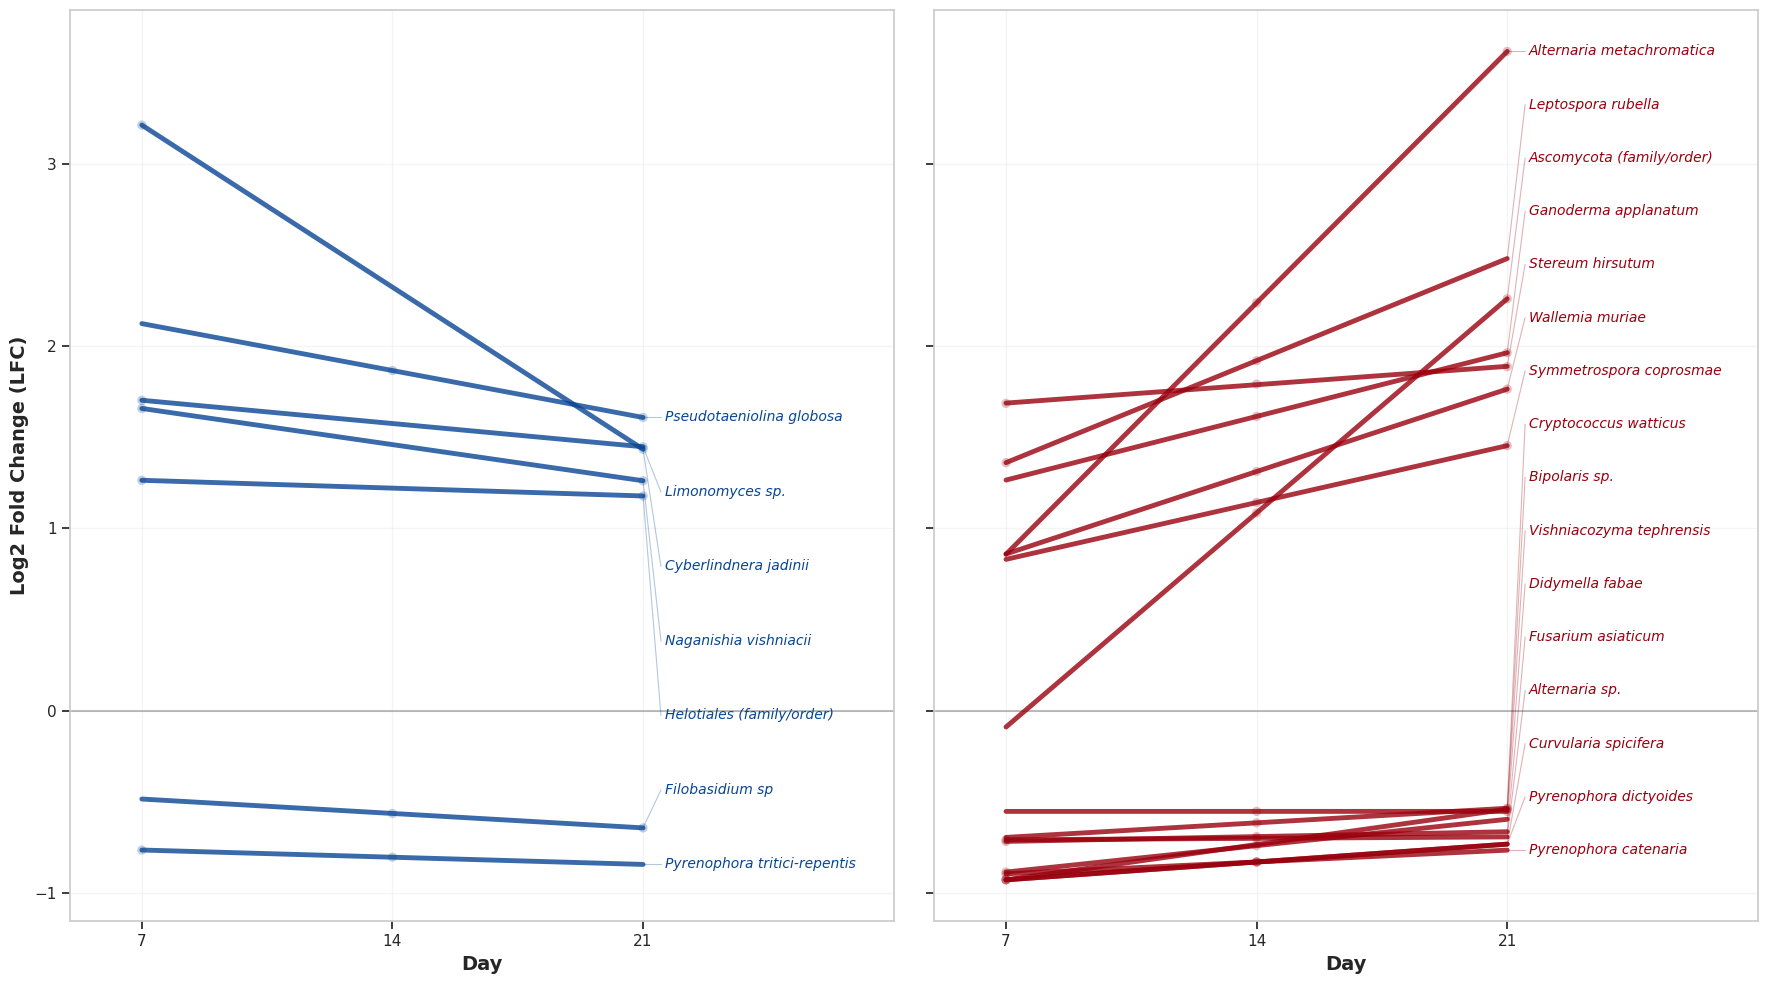


23 species with significant directional changes (p < 0.05 for slope):
  Transfer: 7
  Depletion: 16

DISPLAY NAME                                  | Slope   | R²    | P-Value 

--- TRANSFER TAXA ---
Cyberlindnera jadinii                         | -0.1271 | 1.00 | 0.00e+00
Pseudotaeniolina globosa                      | -0.0368 | 1.00 | 0.00e+00
Naganishia vishniacii                         | -0.0284 | 1.00 | 0.00e+00
Limonomyces sp.                               | -0.0182 | 1.00 | 0.00e+00
Filobasidium sp                               | -0.0113 | 1.00 | 0.00e+00
Helotiales (family/order)                     | -0.0061 | 1.00 | 0.00e+00
Pyrenophora tritici-repentis                  | -0.0056 | 1.00 | 0.00e+00

--- DEPLETION TAXA ---
Alternaria metachromatica                     |  0.1972 | 1.00 | 0.00e+00
Ascomycota (family/order)                     |  0.1680 | 1.00 | 0.00e+00
Leptospora rubella                            |  0.0801 | 1.00 | 0.00e+00
Wallemia muriae                     

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats

# === 1. TAXONOMY EXTRACTION FUNCTION ===
def extract_species_name(full_taxonomy):
    """Extracts the most specific name available, avoiding empty underscores."""
    if not isinstance(full_taxonomy, str) or full_taxonomy.strip() == "" or full_taxonomy == "__":
        return "Unknown Taxon"
        
    parts = [p.strip() for p in full_taxonomy.split(';')]
    
    # Dictionaries to hold the ranks
    ranks = {'s__': '', 'g__': '', 'f__': '', 'o__': '', 'c__': '', 'p__': ''}
    
    for part in parts:
        for key in ranks.keys():
            if part.startswith(key):
                # Clean name: remove prefix and underscores
                name = part.replace(key, '').replace('_', ' ').strip()
                if name: # Only store if not empty
                    ranks[key] = name

    # 1. Try Species + Genus
    if ranks['s__'] and ranks['g__']:
        if ranks['s__'].lower().startswith(ranks['g__'].lower()):
            return ranks['s__']
        return f"{ranks['g__']} {ranks['s__']}"
    
    # 2. Try Genus only
    if ranks['g__']:
        return f"{ranks['g__']} sp."
    
    # 3. Fallback to Family, Order, etc.
    for rank in ['f__', 'o__', 'c__', 'p__']:
        if ranks[rank]:
            return f"{ranks[rank]} (family/order)"

    # 4. Ultimate fallback: last part that isn't just an underscore
    clean_parts = [p.split('__')[-1].replace('_', ' ').strip() for p in parts if len(p.split('__')[-1].replace('_', ' ').strip()) > 0]
    return clean_parts[-1] if clean_parts else "Unclassified Taxon"

# === 2. DATA PREPARATION & REGRESSION ===
# Combine all days and filter significant species (q_val < 0.05)
combined_sterile = pd.concat([
    df[df['q_val'] < 0.05].assign(day=day) 
    for day, df in results_species_level_non_sterile.items()
])

# Regression Analysis
regression_results = []
for species, data in combined_sterile.groupby('id'):
    slope, intercept, r_value, p_value, _ = stats.linregress(data['day'], data['lfc'])
    regression_results.append({
        'species': species,
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2,
        'p_value': p_value
    })

regression_df = pd.DataFrame(regression_results).sort_values('slope')

# CLASSIFICATION LOGIC (p < 0.05 and direction)
regression_df['pattern'] = regression_df.apply(
    lambda r: 'Transfer' if r['p_value'] < 0.05 and r['slope'] < 0 
    else 'Depletion' if r['p_value'] < 0.05 and r['slope'] > 0 
    else 'No change', axis=1
)

# Filter for significant directional changes
filtered_df = regression_df[regression_df['pattern'] != 'No change'].copy()
filtered_df['display_name'] = filtered_df['species'].apply(extract_species_name)
selected_species = filtered_df

# === 3. VISUALIZATION (Prominent Lines & Faceted) ===
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), sharey=True)

axes = {'Transfer': ax1, 'Depletion': ax2}
colors = {'Transfer': '#084594', 'Depletion': '#99000d'}

for pattern in ['Transfer', 'Depletion']:
    ax = axes[pattern]
    subset = selected_species[selected_species['pattern'] == pattern].copy()
    
    # Sort for cleaner labeling
    subset['final_y'] = subset['slope'] * 21 + subset['intercept']
    subset = subset.sort_values('final_y')
    
    color = colors[pattern]
    
    for _, reg in subset.iterrows():
        species_data = combined_sterile[combined_sterile['id'] == reg['species']].sort_values('day')
        
        # Plot data points
        ax.scatter(species_data['day'], species_data['lfc'], 
                   color=color, s=45, alpha=0.25, edgecolors='none', zorder=2)
        
        # Prominent Regression Lines
        x_line = np.array([7, 14, 21])
        y_line = reg['slope'] * x_line + reg['intercept']
        ax.plot(x_line, y_line, color=color, linewidth=3.5, alpha=0.8, zorder=3)

    # Rank-based Labeling
    if not subset.empty:
        y_min, y_max = subset['final_y'].min(), subset['final_y'].max()
        spread_y = np.linspace(y_min, y_max, len(subset)) if len(subset) > 1 else [y_min]
        
        for i, (_, reg) in enumerate(subset.iterrows()):
            actual_y = reg['final_y']
            target_y = spread_y[i]
            
            ax.text(21.6, target_y, reg['display_name'], 
                    fontsize=10, color=color, va='center', fontweight='medium', fontstyle='italic')
            
            # Helper connector lines
            ax.plot([21, 21.5], [actual_y, target_y], color=color, lw=0.8, alpha=0.3)

    # Axis Formatting
    ax.axhline(0, color='black', linestyle='-', linewidth=1.2, alpha=0.3)
    ax.set_xticks([7, 14, 21])
    ax.set_xlim(5, 28)
    ax.set_xlabel('Day', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.2)

# Updated Y-Label
ax1.set_ylabel('Log Fold Change (LFC)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# === 4. SUMMARY STATISTICS ===
print(f"\n{len(filtered_df)} species with significant directional changes (p < 0.05 for slope):")
print(f"  Transfer: {(filtered_df['pattern'] == 'Transfer').sum()}")
print(f"  Depletion: {(filtered_df['pattern'] == 'Depletion').sum()}")

print("\n" + "="*80)
print(f"{'DISPLAY NAME':<45} | {'Slope':<7} | {'R²':<5} | {'P-Value':<8}")
print("="*80)

for p in ['Transfer', 'Depletion']:
    print(f"\n--- {p.upper()} TAXA ---")
    # Sort by absolute slope to show strongest trends first
    subset = filtered_df[filtered_df['pattern'] == p].sort_values('slope', ascending=(p=='Transfer'))
    for _, row in subset.iterrows():
        print(f"{row['display_name']:45} | {row['slope']:7.4f} | {row['r_squared']:.2f} | {row['p_value']:.2e}")